### Importing Libraries

In [ ]:
# Import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from statsmodels.tsa.ar_model import AutoReg

# Table of Contents

- Project Motivation: Background and Framing Question

- Description of Data: Response Data and Predictor Data; Intro to AutoRegression

- Exploratory Data Analysis: Scaling, Generation by Source, Combining Fossil Fuels

- Modeling Approach: AutoRegression, Linear Regression, and Lasso

- Model Results: Linear Regression and Lasso Model Comparisons, Optimizing Training Data Range, Projecting to 2035

- Future Work: Adjusting Predictor Projections, Including Confidence Intervals

# Project Motivation

##     Background

Risks associated with anthropogenic climate change threaten to uproot the lives of massive fractions of our global population. With such a large-scale phenomenon, there is more work to be done than any one person can possibly track. A clear area to focus on, however, is halting whatever processes are contributing to the worsening of this crisis. The driving factor for rising average surface temperatures is increased atmospheric carbon dioxide levels over time, which is linked directly to our cumulative burning of fossil fuels. Replacing fossil fuels with sustainable alternatives for our energy generation is, therefore, one of the most urgent causes of the modern day.

The United States has the highest cumulative emissions of any nation, accounting for 25% of all global emissions. While we have worked to reduce our emissions in recent decades, we still contribute over 11% of global annual emissions. The US is also the world’s largest economy, with our GDP accounting for about 25% of the global GDP. We should prioritize taking responsibility for our contribution to climate change and use our massive economy to lead the world in reducing emissions.

Luckily, this mentality has caught on at the highest levels of our government: the Biden Administration in 2021 set a national goal of realizing a net-zero emission electricity grid by 2035, followed by a net-zero emissions economy by 2050. While these goals inspire optimism, our path to realizing these goals is not clear or easy. As we will see in our data exploration section below, about 60% of our electricity grid today is generated by fossil fuels. Changing our nation’s electricity infrastructure from 60% fossil fuels to (near) 0% in less than 15 years must be one of the most ambitious efforts we have ever pursued.

Data science will surely be a useful tool in tracking the evolution of our power grid and understanding how to better reduce our emissions. With all of this in mind, we pose the following project question.

##     Framing Question

How can historical electricity generation data, combined with critical predictors, be leveraged to develop a predictive model for future electricity generation in the United States? Furthermore, how can this model inform strategic decisions to achieve the ambitious goal of a net-zero carbon electricity grid by 2035, as set by the White House in December 2021?

# Description of Data

##     Response data: Electricity Generation by Source in the United States

Our primary dataset that will function as our response variable in our modeling attempts is historical electricity generation by source in the United States. This data contains quantities of generation (in GeV) for each generation source from 1949 to 2022, with natural gas, coal, nuclear, wind, hydropower, and solar being the dominant generators. The United States Energy Information Agency (EIA) provides this data here. The data comes in both monthly and annual quantities. We could only find yearly data for most of our predictors, so we used the yearly generation data for this project.

The code below imports the data, performs initial cleaning steps (isolating the yearly data, replacing missing values with zeros, compiling each generation source into its own column), and creates a cleaned DataFrame “response_df” which we will explore and model in the subsequent sections.

In [ ]:
# Read electricity generation data
gen_df = pd.read_csv("/work/generation_by_source.csv")
display(gen_df)

,MSN,YYYYMM,Value,Column_Order,Description,Unit
0,CLETPUS,194913,135451.32,1,"Electricity Net Generation From Coal, All Sectors",Million Kilowatthours
1,CLETPUS,195013,154519.994,1,"Electricity Net Generation From Coal, All Sectors",Million Kilowatthours
2,CLETPUS,195113,185203.657,1,"Electricity Net Generation From Coal, All Sectors",Million Kilowatthours
3,CLETPUS,195213,195436.666,1,"Electricity Net Generation From Coal, All Sectors",Million Kilowatthours
4,CLETPUS,195313,218846.325,1,"Electricity Net Generation From Coal, All Sectors",Million Kilowatthours
...,...,...,...,...,...,...
8848,ELETPUS,202303,329856.168,13,Electricity Net Generation Total (including fr...,Million Kilowatthours
8849,ELETPUS,202304,300343.527,13,Electricity Net Generation Total (including fr...,Million Kilowatthours
8850,ELETPUS,202305,327858.999,13,Electricity Net Generation Total (including fr...,Million Kilowatthours
8851,ELETPUS,202306,357140.257,13,Electricity Net Generation Total (including fr...,Million Kilowatthours


In [ ]:
# Extract year and month information from YYYYMM column
gen_df['Year'] = gen_df['YYYYMM']//100
gen_df['Month'] = gen_df['YYYYMM']%100

# Create dataframe with only yearly data
gen_yearly_df = gen_df[gen_df['Month']==13]

# Create a DataFrame for yearly generation by energy source
gen_yearly_bysource_df = pd.DataFrame()
gen_yearly_bysource_df['Year'] = gen_yearly_df[gen_yearly_df['Description']=='Electricity Net Generation From Coal, All Sectors']['Year']
gen_yearly_bysource_df.reset_index(inplace=True, drop=True)

categories = ['Coal','Petroleum','Natural Gas','Other Gases','Nuclear Electric Power','Hydroelectric Pumped Storage',
              'Wood','Waste','Geothermal','Solar','Wind']

for cat in categories:
    gen_yearly_bysource_df[cat] = gen_yearly_df[gen_yearly_df['Description']==f'Electricity Net Generation From {cat}, All Sectors']['Value'].reset_index(drop=True)

gen_yearly_bysource_df['Hydroelectric'] = gen_yearly_df[gen_yearly_df['Description']=='Electricity Net Generation From Conventional Hydroelectric Power, All Sectors']['Value'].reset_index(drop=True)
gen_yearly_bysource_df['Total Generation (10^6 kWh)'] = gen_yearly_df[gen_yearly_df['Description']=='Electricity Net Generation Total (including from sources not shown), All Sectors']['Value'].reset_index(drop=True)

# Data cleaning: Replace 'Not Available' with 0 and convert to float
response_df = gen_yearly_bysource_df.drop('Total Generation (10^6 kWh)', axis=1)
response_df.replace(to_replace='Not Available', value=0, inplace=True)
response_df = response_df.astype(float)
response_df['Year'] = response_df['Year'].astype(int)

print("Shape of the Electricity Generation by Source Dataset after cleaning, (num years, num columns):", response_df.shape)
print(response_df.describe())

Shape of the Electricity Generation by Source Dataset after cleaning, (num years, num columns): (74, 13)
              Year          Coal      Petroleum   Natural Gas   Other Gases  \
count    74.000000  7.400000e+01      74.000000  7.400000e+01     74.000000   
mean   1985.500000  1.135788e+06  106444.727432  5.289339e+05   5760.286784   
std      21.505813  5.936175e+05   90095.180466  4.382640e+05   6383.542893   
min    1949.000000  1.354513e+05   17341.015000  3.696671e+04      0.000000   
25%    1967.250000  6.440887e+05   37080.336750  2.515638e+05      0.000000   
50%    1985.500000  1.176783e+06   85340.974500  3.494344e+05      0.000000   
75%    2003.750000  1.672854e+06  128215.180250  7.053264e+05  12560.562250   
max    2022.000000  2.016456e+06  365060.441000  1.689465e+06  15600.022000   

       Nuclear Electric Power  Hydroelectric Pumped Storage          Wood  \
count               74.000000                     74.000000     74.000000   
mean            403254.790784

##     Predictor Data

Many predictors are likely relevant to the composition of the US electricity grid. Here, we focus on a couple of categories of predictors to identify a compelling list that isn’t so long as to risk overfitting our dataset.

###         Renewable Energy Predictors

Photovoltaic Prices: Reduction in the cost of photovoltaic solar panels in the last few decades is a primary driver of the expansion of solar generation in the US. To capture this effect, we include a predictor variable that is the price of photovoltaic cells (2018$/kWh) from 1975 to 2020. The International Energy Agency (IEA) provides this data here.

In [ ]:
# Read data for photovoltaic prices
pv_df = pd.read_csv('/work/PV_module_cost_1975-2020.csv')
print(pv_df.describe())

              Year  PV module cost/W (2015 $)
count    46.000000                  46.000000
mean   1997.500000                  12.873913
std      13.422618                  21.776822
min    1975.000000                   0.200000
25%    1986.250000                   2.675000
50%    1997.500000                   5.600000
75%    2008.750000                   9.175000
max    2020.000000                 105.700000


Lithium-ion Battery Prices: A major constraint of renewables is the inconsistency of their generation. Essentially, the wind isn’t always blowing; sometimes clouds block the sun, and these fluctuations are restrictingly difficult to model. One potential solution to this is incorporating more energy storage into the grid, most obviously in the form of batteries. Li-ion batteries, in particular, have become much cheaper since their commercial release in 1991, such that many households purchasing solar panels are opting to purchase lithium batteries as well so they can operate entirely off of their solar generation. We include historical lithium-ion battery prices from 1991 to 2020 as a predictor variable to hopefully capture this aspect of a renewable grid. This data was included in a publication available here.

One thing to note is that this predictor narrows our dates quite substantially, as li-ion batteries were not sold before 1991. For this reason, we will not include this predictor in this project. However, as you will see further down, our optimal model trains on data within this dataset's range of values. Future work would include updating our model to include this predictor (see Future Work at the end of the project). For now, we show the data description for the sake of completeness.

In [ ]:
# Read data for Li-ion battery prices
li_price_df = pd.read_csv(f'/work/Li-ion_battery_prices_all_cells.csv')
print(li_price_df.describe())

              Year  Price All Cells (2018 USD per kWh)
count    30.000000                           30.000000
mean   2005.500000                         1826.818187
std       8.803408                         2130.169142
min    1991.000000                          137.000000
25%    1998.250000                          407.864189
50%    2005.500000                          608.624907
75%    2012.750000                         2805.939492
max    2020.000000                         7523.284130


R&D Investment: Renewable generation relies on research and design investment in the public and private sectors to become cost-competitive with fossil fuels. For example, we recently reached the point where solar panels are as cheap (or even cheaper in some cases) as natural gas and coal in terms of $/kWh. We include R&D investment in renewables (Million $) from 1978 to 2023 as a predictor variable to account for this trend. The data can be found here.

In [ ]:
renewable_df = pd.read_csv('renewable_R&D_1978-2023.csv')
print(renewable_df.describe())

              Year   Renewables
count    46.000000    46.000000
mean   2000.500000   814.425145
std      13.422618   570.898414
min    1978.000000   261.685209
25%    1989.250000   416.761648
50%    2000.500000   628.603983
75%    2011.750000   945.226206
max    2023.000000  2539.769532


###         Fossil Fuel Predictors

Natural Gas Prices: From an economic perspective, we use fossil fuels because they are cheap and convenient. Our model would inherently be incomplete if it did not include an indicator of the cost of fossil fuels. Natural gas accounts for the largest single generator output in the US, so we include natural gas price (in $/MMBtu) from 1980 to 2020 as a predictor variable.

Coal Prices: Following the rationale above for natural gas prices, coal is the US's second-largest fossil fuel generation source. Therefore, we also include coal prices (in $/MMBtu) from 1980 to 2020 as a predictor variable. Both the natural gas and coal data can be found here.

In [ ]:
gas_coal_df = pd.read_csv('coal_and_natural_gas_prices_1980-2022.csv')
gas_coal_df = gas_coal_df.dropna(how='all')
gas_coal_df = gas_coal_df.dropna(axis=1, how='all')

min_year = int(min(gas_coal_df['Year']))
max_year = int(max(gas_coal_df['Year']))
all_years = np.linspace(min_year, max_year, max_year-min_year+1)

all_gas = np.zeros(len(all_years))
all_coal = np.zeros(len(all_years))

# For years 1980-2005, data is split into 5 year increments rather than the desired 1 year. Below, we perform
# a linear extrapolation to fill-in the values, assuming linearity between the five year gaps.

for halfdec in range(6):
    for yr in range(5):
        all_gas[5*halfdec + yr] = gas_coal_df['Natural Gas'][halfdec] + (gas_coal_df['Natural Gas'][halfdec+1]-gas_coal_df['Natural Gas'][halfdec])*(yr)/5
        all_coal[5*halfdec + yr] = gas_coal_df['Coal'][halfdec] + (gas_coal_df['Coal'][halfdec+1]-gas_coal_df['Coal'][halfdec])*(yr)/5

for i in range(30, len(all_years)):
    all_gas[i] = gas_coal_df['Natural Gas'][i-24]
    all_coal[i] = gas_coal_df['Coal'][i-24]

gas_coal_interp_df = pd.DataFrame()
gas_coal_interp_df['Year'] = all_years
gas_coal_interp_df['Natural Gas'] = all_gas
gas_coal_interp_df['Coal'] = all_coal
print(gas_coal_interp_df.describe())

              Year  Natural Gas       Coal
count    43.000000    43.000000  43.000000
mean   2001.000000     3.984186   1.694884
std      12.556539     1.771530   0.387023
min    1980.000000     1.980000   1.200000
25%    1990.500000     2.620000   1.385000
50%    2001.000000     3.370000   1.540000
75%    2011.500000     5.086000   2.040000
max    2022.000000     8.210000   2.390000


###         Grid Scale Predictors

US Population: None of the above accounts for the overall scale of our electricity grid, which is projected to double in size by 2050 as we electrify more tasks that have historically run on fossil fuels (like EVs, for example). One variable that captures some of this growth is the US Population: as our population has grown, so too has our energy grid. We include the US Population (in number of people) from 1910 to 2020 as a predictor variable. Our data source is the US Census (provided here), which provides US population data per decade, not per year as we desire. Therefore, we perform a linear extrapolation to create approximate population data per year, assuming a linear change in population within a given decade.

In [ ]:
census_df = pd.read_csv('census_data.csv')

pop_df = pd.DataFrame()
US_df = census_df[census_df['Name']=='United States']
US_df = US_df.reset_index()
US_df = US_df.replace (',', '', regex=True)
US_df['Resident Population'] = US_df['Resident Population'].astype(float)

pop_df['Year'] = np.linspace(1910, 2020, 111)
pop_interp = np.zeros(111)

# Linear extrapolation to fit decade data into yearly data.
for dec in range(11):
    for yr in range(10):
        pop_interp[10*dec + yr] = US_df['Resident Population'][dec] + (US_df['Resident Population'][dec+1]-US_df['Resident Population'][dec])*(yr)/10
pop_interp[110] = US_df['Resident Population'][11]
pop_df['Population'] = np.round(pop_interp)
#pop_df['Population'] = census_df[census_df['Name']=='United States']['Resident Population']
print(pop_df.describe())


              Year    Population
count   111.000000  1.110000e+02
mean   1965.000000  1.976303e+08
std      32.186954  7.296752e+07
min    1910.000000  9.222853e+07
25%    1937.500000  1.299245e+08
50%    1965.000000  1.912676e+08
75%    1992.500000  2.568879e+08
max    2020.000000  3.314493e+08


###         Autoregression: Response as Predictors

For time-based functions, like our generation data here or stock values as another example, the function is often self-correlated, meaning its current and future values depend on its own prior values. To build intuition for this, it seems clear that the US electricity generation will not change drastically in one year. Even from a labor perspective, we likely cannot build the infrastructure for 50% of our required electricity generation in only one year. Therefore, the US generation data does not change too drastically on a year-to-year basis, and therefore, we might expect a correlation between a given year’s generation data and the year prior’s data.

Models that take advantage of this are known as autoregression models. An autoregression model works much like the linear regression we’ve learned about in class but with predictors that are time-shifted versions of the response variable: 

y(t) = x0 + x1 * y(t-t1) + x2 * y(t-t2)

The above linear regression, for example, contains coefficients for an intercept (x0), the response variable a time t1 before the modeled time t (x1), and the response variable a time t2 before t (x2). This is an example of autoregression with two predictors, although the model can be generalized to allow for any number of predictors, only constrained by the size of the response dataset.

We will include autoregression predictors and the abovementioned predictors in our model, creating a hybrid linear/auto-regression model. The following section will optimize the hyperparameters (t1 and t2 above) via cross-validation.

Below, we define a function called “autoregression” that takes in a data frame of the response variable and a value to shift the indices by and returns a data frame with the indices shifted by the desired value. We present a simple plot demonstrating the behavior of this function, which we will use later to generate our autoregression predictors.

Text(0.5, 1.0, 'Demonstrating Autoregression Function: Natural Gas Generation Shifted by 10 Years')

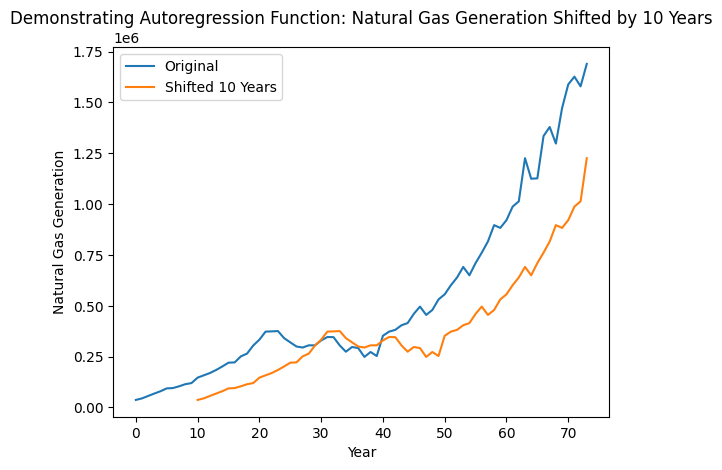

In [ ]:
# Create a function that returns a DataFrame with data in 'Year' column shifted by a number of years, t0. WIll
# use this function to creat autoregression predictors.
def autoregression(data, t0):
    """
    data: DataFrame representing desired response variable. Assumes index is timestamps.
    t0: time shift to shift data indices backwards by. 
    Returns DataFrame: data with indices shifted by t0
    """
    max_year = max(data.index)
    df = data.shift(periods=t0)
    df = df.dropna()
    return df

source = 'Natural Gas'
shift = 10
plt.plot(response_df.index, response_df[source], label='Original')
auto_reg = autoregression(response_df, shift)
plt.plot(auto_reg.index, auto_reg[source], label=f'Shifted {shift} Years')
plt.legend()
plt.xlabel('Year')
plt.ylabel(f'{source} Generation')
plt.title(f'Demonstrating Autoregression Function: {source} Generation Shifted by {shift} Years')

# Exploratory Data Analysis

##     Merge and Scale Predictors

Our predictors have a variety of y-scales, which would affect the fitted coefficients from a linear regression model. To avoid this, we merge and scale our predictors below so that they all share the same scale.

In [ ]:
#Merge and scale predictor variables
predictors = pd.DataFrame()
ind_predictors = [pv_df, renewable_df, gas_coal_interp_df, pop_df]
for pred in ind_predictors:
    if len(predictors)==0:
        predictors = pred
    else:
        predictors = predictors.merge(pred, how='outer')

# To avoid scaling 'Year', we make the index values equal to 'Year' since this is the desired function of the 'Year' column anyway.
predictors = predictors.set_index('Year')
predictors = predictors.dropna()
predictors.columns = ['PV Price', 'Renewable R&D', 'Natural Gas Price', 'Coal Price', 'Population']

scaler = StandardScaler().fit(predictors)
scaled_predictors = pd.DataFrame(scaler.transform(predictors), columns=['PV Price', 'Renewable R&D', 'Natural Gas Price', 'Coal Price', 'Population'], index=predictors.index)
display(scaled_predictors.describe())


,PV Price,Renewable R&D,Natural Gas Price,Coal Price,Population
count,4.100000e+01,4.100000e+01,4.100000e+01,4.100000e+01,4.100000e+01
mean,-5.686508e-17,1.245616e-16,-1.462245e-16,2.030896e-16,7.148753e-16
std,1.012423e+00,1.012423e+00,1.012423e+00,1.012423e+00,1.012423e+00
min,-9.690185e-01,-9.847102e-01,-1.110912e+00,-1.260976e+00,-1.621111e+00
25%,-6.827352e-01,-6.832910e-01,-7.803830e-01,-8.009448e-01,-9.420435e-01
50%,-2.215010e-01,-3.181674e-01,-3.783563e-01,-3.783580e-01,6.019435e-02
75%,1.443054e-01,4.235670e-01,6.589431e-01,9.321959e-01,8.973413e-01
max,3.770560e+00,3.969901e+00,2.540147e+00,1.921798e+00,1.592943e+00


As we can see above, each scaled column has a mean value very close to 0, and a standard deviation very close to 1. This is the result of our scaling process. Below we see this relationship on the boxplot. This allows us to get a clearer view of each variable's central tendency, dispersion, and possible outliers.

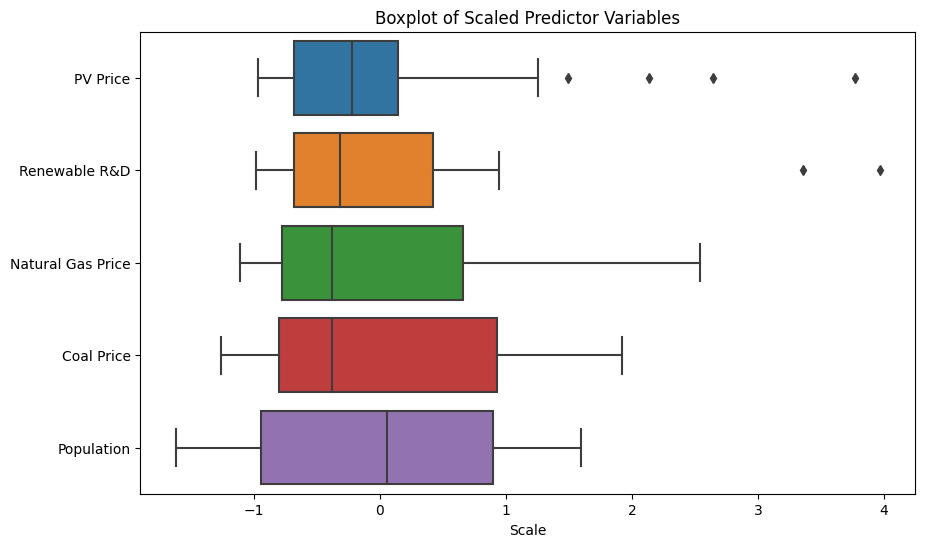

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=scaled_predictors, orient='h')
plt.title('Boxplot of Scaled Predictor Variables')
plt.xlabel('Scale')
plt.show()

##     Generation Data by Source over Time

In [ ]:
# Want to identify which generation sources are dominant and which, if any, we can neglect.
response_df = response_df.set_index('Year')
print('Generation sources sorted by generation value, 1980:')
print(response_df.loc[1980].sort_values())
print('Generation sources sorted by generation value, 2022:')
print(response_df.loc[2022].sort_values())


Generation sources sorted by generation value, 1980:
Other Gases                           0.000
Hydroelectric Pumped Storage          0.000
Solar                                 0.000
Wind                                  0.000
Waste                               157.797
Wood                                275.366
Geothermal                         5073.079
Petroleum                        245994.189
Nuclear Electric Power           251115.575
Hydroelectric                    279182.090
Natural Gas                      346239.900
Coal                            1161562.368
Name: 1980, dtype: float64
Generation sources sorted by generation value, 2022:
Hydroelectric Pumped Storage      -6033.905
Other Gases                       11884.468
Waste                             16888.916
Geothermal                        17002.007
Petroleum                         23383.078
Wood                              36569.213
Solar                            145598.313
Hydroelectric                  

From the above, we see that in 1980, the dominant generation sources were coal, natural gas, hydroelectric, nuclear, and petroleum. In 2022, the dominant sources were natural gas, coal, nuclear, wind, hydroelectric, and solar. Therefore, we will focus our model on including the following sources: natural gas, coal, nuclear, wind, hydroelectric, solar, and petroleum.

In [ ]:
# Drop undesired columns
response_df = response_df.drop(labels=['Other Gases', 'Hydroelectric Pumped Storage', 'Waste', 'Wood', 'Geothermal'], axis=1)

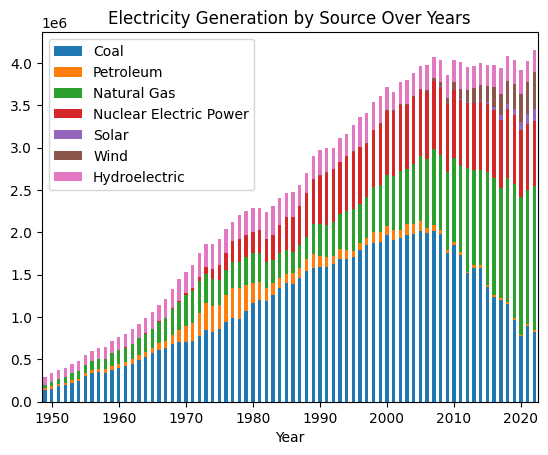

In [ ]:
#Plot bar chart for electricity generation by source over the years
ax = response_df.plot.bar(stacked=True)
ax.set_xticks(ticks=[1, 11, 21, 31, 41, 51, 61, 71],
            labels=[1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020], rotation=0)
plt.title('Electricity Generation by Source Over Years')
ax.legend()

##     Condensing Generation Data: Combine Fossil Fuels and Convert to Percentage

A difficulty with the response dataset so far is that we have seven different responses, namely the seven different generation sources. Really, what we are interested in modeling is how much of the total generation is from fossil fuels over time. Therefore, we will simplify our response variable by adding the fossil fuel generation columns (natural gas, coal, petroleum) and dividing that sum by the total sum of all generation sources. This will result in a column representing the percentage of US electricity generation from fossil fuels over time.

,Carbon,Non-carbon,Total,Carbon Fraction
Year,,,,
1949,200965.261,94772.992,295738.253,0.679538
1950,232813.441,100884.575,333698.016,0.697677
1951,270531.451,104376.120,374907.571,0.721595
1952,293639.515,109708.251,403347.766,0.728006
1953,337041.749,109617.396,446659.145,0.754584


(0.0, 1.0)

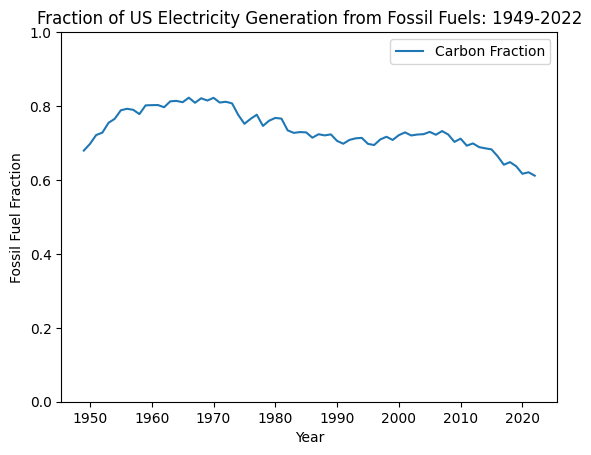

In [ ]:
carbon_df = pd.DataFrame()
#carbon_df['Year'] = df['Year']
carbon_df['Carbon'] = response_df['Natural Gas'] + response_df['Coal'] + response_df['Petroleum']
carbon_df['Non-carbon'] = response_df['Nuclear Electric Power'] + response_df['Wind'] + response_df['Hydroelectric'] + response_df['Solar']
carbon_df['Total'] = carbon_df['Carbon'] + carbon_df['Non-carbon']
carbon_df['Carbon Fraction'] = carbon_df['Carbon']/carbon_df['Total']
carbon_df.index = response_df.index

display(carbon_df.head())

ax = carbon_df.plot(y='Carbon Fraction')
ax.set_ylabel('Fossil Fuel Fraction')
ax.set_title('Fraction of US Electricity Generation from Fossil Fuels: 1949-2022')
ax.set_ylim([0,1])


This simplified response data perfectly captures what we are interested in from the original source data. We now move to modeling this data.

# Modeling Approach

##     AutoRegression

###         Identify optimal autoregression predictor(s)

To start, we aim to identify two optimal autoregression predictors. Intuitively, we suspect that one autoregression predictor with a small shift value (close to 1 year) might capture the small year-to-year change of our response variable; another autoregression predictor with a larger shift value (maybe ten years or so) might capture the longer-term reduction in fossil fuel generation we are striving for. But as we find below, only small shift values demonstrate autocorrelation and are valuable in an autoregression model.

,Shifts,Train Scores,"Test Scores, Data","Test Scores, Prediction"
2,3,0.568891,0.821634,0.738716
0,1,0.828312,-0.048932,-1.586156
1,2,0.717464,-1.456581,-2.029149
3,4,0.382424,-5.612478,-5.612478
4,5,0.205079,-18.328282,-18.328282
5,6,0.064621,-42.294106,-42.294106
13,14,0.097058,-58.534497,-58.534497
14,15,0.042183,-62.839227,-62.839227
12,13,0.227896,-66.250200,-66.250200
6,7,0.005062,-66.261146,-66.261146


Best year shift value: 3 (test score = 0.738716255934993)
Coefficients: [1.28671536]
Intercept: -0.2107030501141961


Text(0.5, 1.0, 'Autoregression test: best simple model, lag=3 year')

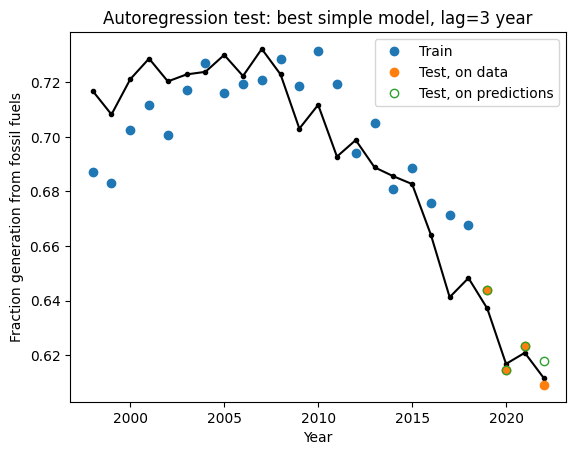

In [ ]:
shifts = [i for i in range(1,20)]

start_year = 1998 #Changed this value as we optimized start_year in the code section below this one
end_year = 2022

y_all_years = carbon_df['Carbon Fraction']
#print(y_all_years)
models = []
train_scores = []
test_scores = []
test_scores_prediction = []
X_trains = []
X_tests = []
y_trains = []
y_tests = []
y_tests_predictions = []

for shift in shifts:
    X = autoregression(y_all_years, shift)
    X = X.loc[start_year:end_year]
    y = y_all_years.loc[start_year:end_year]
    #print(f'X: {X}')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)
    X_train = X_train.values.reshape(-1,1)
    X_test = X_test.values.reshape(-1,1)
    model = LinearRegression()
    model = model.fit(X=X_train, y=y_train)
    train_score = model.score(X=X_train, y=y_train)
    test_score = model.score(X=X_test, y=y_test)
    models.append(model)
    train_scores.append(train_score)
    test_scores.append(test_score)
    X_trains.append(X_train)
    X_tests.append(X_test)
    y_trains.append(y_train)
    y_tests.append(y_test)

    # Instead of fitting test results on the actual test data, fit on the model's predictions themselves.
    y_test_pred = [0 for _ in range(len(y_test))]
    for i in range(min([shift,len(y_test_pred)])):
        y_test_pred[i] = model.predict(y_train.iloc[-1*shift+i].reshape(-1,1))
    if len(y_test_pred) > shift:
        for i in range(shift,len(y_test_pred)):
            y_test_pred[i] = model.predict(y_test_pred[i-shift].reshape(-1,1))

    test_scores_prediction.append(r2_score(y_test, y_test_pred))
    y_tests_predictions.append(y_test_pred)

results_df = pd.DataFrame()
results_df['Shifts'] = shifts
results_df['Train Scores'] = train_scores
results_df['Test Scores, Data'] = test_scores
results_df['Test Scores, Prediction'] = test_scores_prediction
results_df = results_df.sort_values(by='Test Scores, Prediction', ascending=False)
display(results_df)

best_shift_index = test_scores_prediction.index(max(test_scores_prediction))
best_shift = shifts[best_shift_index]
best_test_score = test_scores_prediction[best_shift_index]
best_model = models[best_shift_index]

print(f'Best year shift value: {best_shift} (test score = {best_test_score})')
print(f'Coefficients: {best_model.coef_}')
print(f'Intercept: {best_model.intercept_}')

X_train = X_trains[best_shift_index]
X_test = X_tests[best_shift_index]
y_train = y_trains[best_shift_index]
y_test = y_tests[best_shift_index]
y_test_pred = y_tests_predictions[best_shift_index]

train_years = [i for i in range(start_year, start_year+len(y_train))]
test_years = [i for i in range(end_year-len(y_test)+1, end_year+1)]

plt.plot(y.index, y, '.-k')

model_train = best_model.predict(X_train)
model_test = best_model.predict(X_test)

plt.plot(train_years, model_train, 'o', label='Train')
plt.plot(test_years, model_test, 'o', label='Test, on data')

plt.plot(test_years, y_test_pred, 'o', markerfacecolor='none', label='Test, on predictions')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Fraction generation from fossil fuels')
plt.title(f'Autoregression test: best simple model, lag={best_shift} year')

The above table shows that an autoregression model performs best on our response dataset for the smallest lag values. In fact, the first 6 best performing models are for lag times between 1 and 6 years! Further, only a lag time of 3 years has an R^2 value greater than 0.

In the plot above, we show the response generation data from 1998 to 2022 (in black) as well as the simple autoregression model train (blue) and test (orange) predictions for a lag time = 3 years. This choice of year is justified via cross-validation below. Visually, the model's performance is fairly good, albeit misleading: our 'test' model was fit to the 'test' response, just shifted by 1 year. Therefore, calling this a "test" fit is a bit naive.

A better indicator of the generalization of this model would be to use its own predictions as its input going forward in time. This is shown in green, where we give our model the third to last year of the train data to predict the first year of the test response (since the lag = 3), and then we continue this process until we give the model its own predictions. Looking at the plotted points, we see that the test done on predictions alone performs similarly to the test on the actual data, since with a lag time of 3 years, only the final 4th test datapoint results in a difference between these two approaches.

We suspect the accuracy of this testing on predictions should depend strongly on the date range trained on since the recent trend of decreasing fossil fuel usage is relatively new, so older generation data is likely skewing the model towards a more constant generation curve. We perform this check below.

###         Cross-validate starting year for training data

,Start Years,Train Scores,"Test Scores, Data","Test Scores, Prediction"
46,1998,0.568891,0.821634,0.738716
45,1997,0.569885,0.820507,0.736903
47,1999,0.632197,0.395009,0.489532
43,1995,0.482119,-0.078168,-2.086150
44,1996,0.480682,-0.124394,-2.203995
48,2000,0.695153,-1.612582,-2.666596
4,1956,0.810375,0.152861,-2.692072
11,1963,0.834649,-0.183686,-2.977337
12,1964,0.830813,-0.233359,-3.073967
10,1962,0.837953,-0.039222,-3.130268


Best start year: 1998 (test score, prediction = 0.738716255934993)
Coefficients: [1.28671536]
Intercept: -0.2107030501141961


Text(0.5, 1.0, 'Autoregression test: shift = 3 years, start year = 1998')

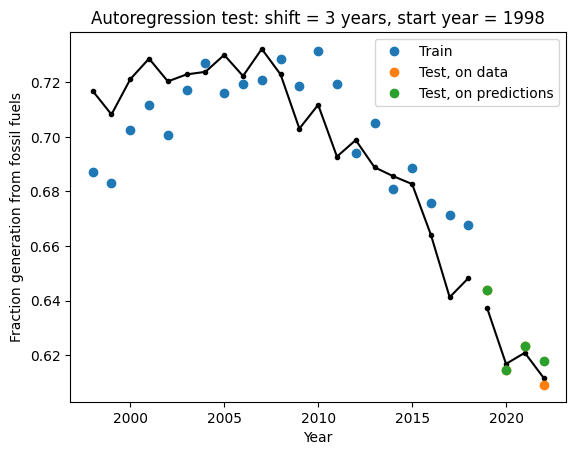

In [ ]:
shift = 3 # Changed this value as we optimized shift 

start_years = [i for i in range(1952, 2002)]
end_year = 2022

y_all_years = carbon_df['Carbon Fraction']

models = []
train_scores = []
test_scores_data = []
test_scores_prediction = []
X_trains = []
X_tests = []
y_trains = []
y_tests = []
y_tests_predictions = []

for start_year in start_years:
    X = autoregression(y_all_years, shift)
    X = X.loc[start_year:end_year]
    y = y_all_years.loc[start_year:end_year]
    #print(f'X: {X}')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)
    X_train = X_train.values.reshape(-1,1)
    X_test = X_test.values.reshape(-1,1)
    model = LinearRegression()
    model = model.fit(X=X_train, y=y_train)
    train_score = model.score(X=X_train, y=y_train)
    test_score_data = model.score(X=X_test, y=y_test)
    models.append(model)
    train_scores.append(train_score)
    test_scores_data.append(test_score_data)
    X_trains.append(X_train)
    X_tests.append(X_test)
    y_trains.append(y_train)
    y_tests.append(y_test)

    # Instead of fitting test results on the actual test data, fit on the model's predictions themselves.
    y_test_pred = [0 for _ in range(len(y_test))]
    for i in range(shift):
        y_test_pred[i] = model.predict(y_train.iloc[-1*shift+i].reshape(-1,1))
    for i in range(shift,len(y_test_pred)):
        y_test_pred[i] = model.predict(y_test_pred[i-shift].reshape(-1,1))

    test_score_prediction = r2_score(y_test, y_test_pred)
    test_scores_prediction.append(test_score_prediction)
    y_tests_predictions.append(y_test_pred)

results_df = pd.DataFrame()
results_df['Start Years'] = start_years
results_df['Train Scores'] = train_scores
results_df['Test Scores, Data'] = test_scores_data
results_df['Test Scores, Prediction'] = test_scores_prediction
results_df = results_df.sort_values(by='Test Scores, Prediction', ascending=False)
display(results_df)

best_year_index = test_scores_prediction.index(max(test_scores_prediction))
best_year = start_years[best_year_index]
#best_year = 2008
best_test_score_prediction = test_scores_prediction[best_year_index]
best_model = models[best_year_index]

print(f'Best start year: {best_year} (test score, prediction = {best_test_score_prediction})')
print(f'Coefficients: {best_model.coef_}')
print(f'Intercept: {best_model.intercept_}')

X_train = X_trains[best_year_index]
X_test = X_tests[best_year_index]
y_train = y_trains[best_year_index]
y_test = y_tests[best_year_index]
y_test_pred = y_tests_predictions[best_year_index]

train_years = [i for i in range(best_year, best_year+len(y_train))]
test_years = [i for i in range(end_year-len(y_test)+1, end_year+1)]

plt.plot(train_years, y_train, '.-k')
plt.plot(test_years, y_test, '.-k')
#plt.plot(y_all_years.loc[best_year:end_year].index, y_all_years.loc[best_year:end_year], '.-', label='Data')

model_train = best_model.predict(X_train)
model_test = best_model.predict(X_test)

plt.plot(train_years, model_train, 'o', label='Train')
plt.plot(test_years, model_test, 'o', label='Test, on data')

plt.plot(test_years, y_test_pred, 'o', label='Test, on predictions')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Fraction generation from fossil fuels')
plt.title(f'Autoregression test: shift = {shift} years, start year = {best_year}')


From iterating back and forth between cross-validating the shift time and the start year (and keeping a constant test sample size of 15%), we found an optimal test on prediction performance for a shift time of 3 years and a start year of 1998, with an R^2 of 0.74. Due to the small sample size, the test data only consists of 4 data points from 2019-2022. However, the nature of the generation data is such that more recent data is more applicable, as our current trend of decreasing fossil fuel generation only began majorly about 10 years ago.

###       Autocorrelation plot

To explore this autoregression modeling further, we performed an autocorrelation plot, as shown below. Pandas has a function “plotting.autocorrelation_plot”, which finds the self-correlation of a dataset as a function of the lag time (equivalent to what we refer to as shift time). A correlation value near 0 implies no correlation, whereas values far from zero imply either positive or negative correlation is present in the data, depending on the sign. The function also plots dashed lines representing the autocorrelation's confidence interval: essentially, autocorrelations outside of these bounds are most likely due to real correlations in the data and not noise. Our plot shows that our autocorrelation value outside of the dashed lines is only for the smallest lag times. This implies that for lag times less than about 4 years, our generation data is indeed autocorrelated. This result matches our above result, showing that by far, the best-performing lag times were 3 years, 2 years, and 1 year.

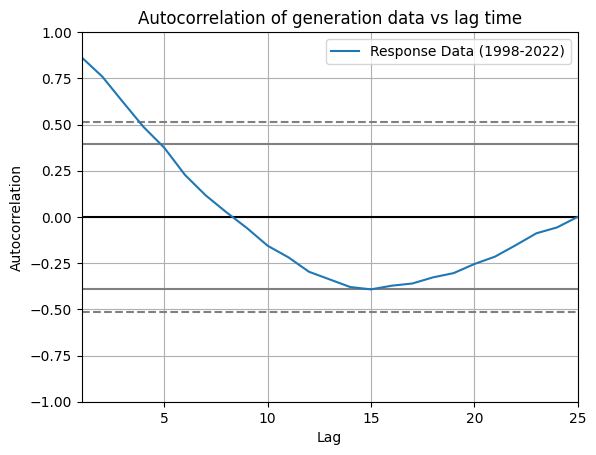

In [ ]:
ax = pd.plotting.autocorrelation_plot(y_all_years.loc[1998:], label='Response Data (1998-2022)')
ax.set_title('Autocorrelation of generation data vs lag time')
ax.legend()

###         Future projections with autoregression: modeling to 2035

As a final demonstration of the autoregression model (for now), we refit our best model above (lag time=3 years, start year = 1998) to fit on all the recent year’s data through 2022 and projected forward in time using the iterative approach described above to model fossil fuel generation out to 2035. The results are plotted below.

Simple autoregression model projected fraction of US electricity grid generated from fossil fuels in 2035: 0.326


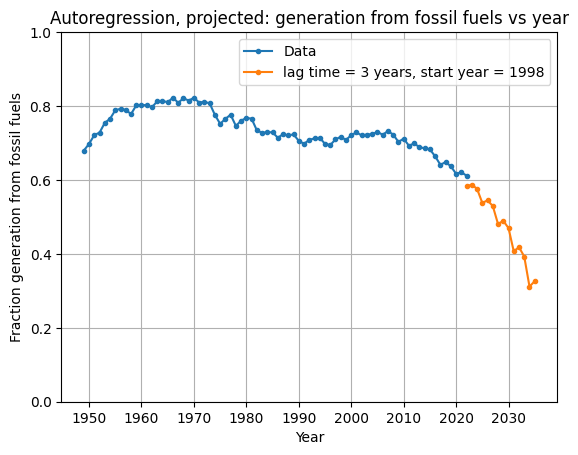

In [ ]:
shift = 3
start_year = 1998

future_years = [i for i in range(2022, 2036)]
y_test_pred = [0 for _ in range(len(future_years))]

X = autoregression(y_all_years, shift)
X = X.loc[start_year:end_year]
X = X.values.reshape(-1,1)
y = y_all_years.loc[start_year:end_year]
model = LinearRegression().fit(X=X, y=y)

for i in range(shift):
    y_test_pred[i] = model.predict(y.iloc[-1*shift+i].reshape(-1,1))
for i in range(shift,len(y_test_pred)):
    y_test_pred[i] = model.predict(y_test_pred[i-shift].reshape(-1,1))

plt.plot(y_all_years.index, y_all_years, '.-', label='Data')
plt.plot(future_years, y_test_pred, '.-', label=f'lag time = {shift} years, start year = {start_year}')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Fraction generation from fossil fuels')
plt.title('Autoregression, projected: generation from fossil fuels vs year')
plt.ylim([0,1])
plt.xticks([1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030])
plt.grid()

print(f'Simple autoregression model projected fraction of US electricity grid generated from fossil fuels in {max(future_years)}: {np.round(y_test_pred[-1][0],3)}')

While the projected value of 33% is still fairly far from the goal of nearly 0%, this is still a dramatic improvement compared to our historical generation and is indicative of the impressive progress made in the last 15 or so years since an autoregression model only comes from trends present in the data itself.

##     Linear Regression Model and Lasso Model with Predictors

###         Full predictor data range: 1980-2020

We now will set up our basic linear regression model using our predictors from earlier. We will begin by including all of our predictor data (a data range of 1980-2020), but we will optimize this via cross-validation further down in the project.

In [ ]:
start_year = 1980
end_year = 2020
test_size = 2.5/(end_year-start_year)

X = scaled_predictors.loc[start_year:end_year]
y = carbon_df['Carbon Fraction'].loc[start_year:end_year]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)


We also set up train and test variables, including our optimal autoregression in our predictors, for comparison to our model without autoregression. Note that we need to re-scale our predictors now since the AutoRegression has not been scaled to match our other predictors!

In [ ]:
X_ar = autoregression(carbon_df['Carbon Fraction'], best_shift).loc[start_year:end_year]

X_with_ar = X.merge(X_ar, how='outer', left_index=True, right_index=True)

# Now rescale predictors so that autoregression is on same scale as rest
scaler = StandardScaler().fit(X_with_ar)
X_with_ar = pd.DataFrame(scaler.transform(X_with_ar), columns=['PV Price', 'Renewable R&D', 'Natural Gas Price', 'Coal Price', 'Population', f'AutoRegression, lag={best_shift}'], index=X_with_ar.index)
print(X_with_ar.describe())

X_with_ar_train, X_with_ar_test, y_train, y_test = train_test_split(X_with_ar, y, test_size=test_size, shuffle=False)

           PV Price  Renewable R&D  Natural Gas Price    Coal Price  \
count  4.100000e+01   4.100000e+01       4.100000e+01  4.100000e+01   
mean   5.415722e-17   5.415722e-18      -5.415722e-18 -4.874150e-17   
std    1.012423e+00   1.012423e+00       1.012423e+00  1.012423e+00   
min   -9.690185e-01  -9.847102e-01      -1.110912e+00 -1.260976e+00   
25%   -6.827352e-01  -6.832910e-01      -7.803830e-01 -8.009448e-01   
50%   -2.215010e-01  -3.181674e-01      -3.783563e-01 -3.783580e-01   
75%    1.443054e-01   4.235670e-01       6.589431e-01  9.321959e-01   
max    3.770560e+00   3.969901e+00       2.540147e+00  1.921798e+00   

         Population  AutoRegression, lag=3  
count  4.100000e+01           4.100000e+01  
mean   3.791005e-17           1.765525e-15  
std    1.012423e+00           1.012423e+00  
min   -1.621111e+00          -2.935494e+00  
25%   -9.420435e-01          -5.254543e-01  
50%    6.019435e-02           1.495722e-01  
75%    8.973413e-01           4.739622e-01  


With our train and test variables defined, we begin with a basic linear regression model. One without autoregression...

In [ ]:
model = LinearRegression().fit(X=X_train, y=y_train)
train_score = model.score(X=X_train, y=y_train)
test_score = model.score(X=X_test, y=y_test)

…and one model with autoregression:

In [ ]:
model_with_ar = LinearRegression().fit(X=X_with_ar_train, y=y_train)
train_with_ar_score = model_with_ar.score(X=X_with_ar_train, y=y_train)
test_with_ar_score = model_with_ar.score(X=X_with_ar_test, y=y_test)

We also fit a Lasso model to compare with our basic linear regression. Here, we perform cross-validation to optimize our choice of alpha for models both with and without the autoregression predictor.

In [ ]:
# Alpha cross-validation, no autoregression predictor:

alphas = [1e-6, 2e-6, 5e-6, 0.00001, 0.00002, 0.00005, 0.0001, .0002, .0005, 0.001, .002, .005, 0.01, .02, .05]
lasso_train_scores = []
lasso_test_scores = []
lasso_models = []

for i in range(len(alphas)):
    alpha = alphas[i]
    lasso_model = Lasso(alpha=alpha).fit(X_train, y_train)
    lasso_train_score = lasso_model.score(X_train, y_train)
    lasso_test_score = lasso_model.score(X_test, y_test)
    lasso_train_scores.append(lasso_train_score)
    lasso_test_scores.append(lasso_test_score)
    lasso_models.append(lasso_model)

alpha_index = lasso_test_scores.index(max(lasso_test_scores))
lasso_alpha = alphas[alpha_index]
lasso_model = lasso_models[alpha_index]
lasso_train_score = lasso_train_scores[alpha_index]
lasso_test_score = lasso_test_scores[alpha_index]


In [ ]:
# Alpha cross-validation, with autoregression predictor:

alphas = [1e-6, 2e-6, 5e-6, 0.00001, 0.00002, 0.00005, 0.0001, .0002, .0005, 0.001, .002, .005, 0.01, .02, .05]
lasso_with_ar_train_scores = []
lasso_with_ar_test_scores = []
lasso_with_ar_models = []

for i in range(len(alphas)):
    alpha = alphas[i]
    lasso_with_ar_model = Lasso(alpha=alpha).fit(X_with_ar_train, y_train)
    lasso_with_ar_train_score = lasso_with_ar_model.score(X_with_ar_train, y_train)
    lasso_with_ar_test_score = lasso_with_ar_model.score(X_with_ar_test, y_test)
    lasso_with_ar_train_scores.append(lasso_with_ar_train_score)
    lasso_with_ar_test_scores.append(lasso_with_ar_test_score)
    lasso_with_ar_models.append(lasso_with_ar_model)

alpha_with_ar_index = lasso_with_ar_test_scores.index(max(lasso_with_ar_test_scores))
lasso_alpha_with_ar = alphas[alpha_with_ar_index]
lasso_with_ar_model = lasso_with_ar_models[alpha_with_ar_index]
lasso_train_with_ar_score = lasso_with_ar_train_scores[alpha_with_ar_index]
lasso_test_with_ar_score = lasso_with_ar_test_scores[alpha_with_ar_index]


# Model Results

##     Linear Regression and Lasso Model Optimization

###         Lasso optimization: plotting our cross-validation results

Text(0.5, 1.0, 'Fit Coefficients vs Alpha, with AutoRegression')

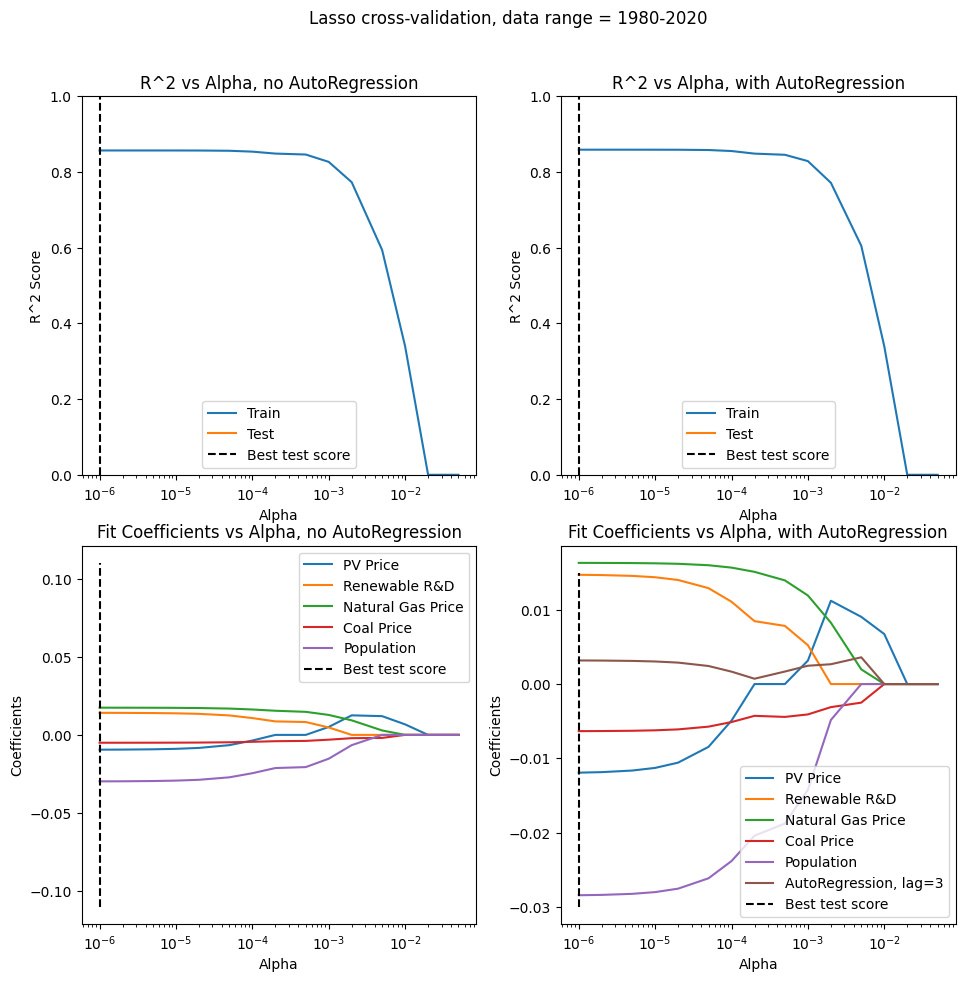

In [ ]:
f, axs = plt.subplots(2,2,figsize=(10,10))

f.suptitle(f'Lasso cross-validation, data range = {start_year}-{end_year}')

plt.subplot(2,2,1)
plt.tight_layout(pad=3)
plt.plot(alphas, lasso_train_scores, label='Train')
plt.plot(alphas, lasso_test_scores, label='Test')
plt.plot([lasso_alpha, lasso_alpha], [0,1], '--k', label='Best test score')
plt.xscale('log')
plt.ylim([0,1])
plt.xlabel('Alpha')
plt.ylabel('R^2 Score')
plt.legend()
plt.title('R^2 vs Alpha, no AutoRegression')

plt.subplot(2,2,2)
plt.plot(alphas, lasso_with_ar_train_scores, label='Train')
plt.plot(alphas, lasso_with_ar_test_scores, label='Test')
plt.plot([lasso_alpha_with_ar, lasso_alpha_with_ar], [0,1], '--k', label='Best test score')
plt.xscale('log')
plt.ylim([0,1])
plt.xlabel('Alpha')
plt.ylabel('R^2 Score')
plt.legend()
plt.title('R^2 vs Alpha, with AutoRegression')


plt.subplot(2,2,3)

plt.plot(alphas, [model.coef_ for model in lasso_models], label=X.columns)
plt.plot([lasso_alpha, lasso_alpha], [-0.11,0.11], '--k', label='Best test score')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.legend()
plt.title('Fit Coefficients vs Alpha, no AutoRegression')


plt.subplot(2,2,4)

plt.plot(alphas, [model.coef_ for model in lasso_with_ar_models], label=X_with_ar.columns)
plt.plot([lasso_alpha_with_ar, lasso_alpha_with_ar], [-0.03,0.015], '--k', label='Best test score')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.legend()
plt.title('Fit Coefficients vs Alpha, with AutoRegression')

Looking at the plots above, we see that our Lasso model (when optimized for test R^2 score) does not shrink any coefficients and is thus essentially just an unregularized linear regression model. If we look at how coefficients shrink with increasing alpha, though, we see that the AutoRegression coefficient is brought to zero at a similar point as the other coefficients, indicating it performs comparably as a predictor to the others. No predictors appear to perform much worse or better than the others.

###     Model comparison: train/test scores, coefficients

Below, we display our train and test scores for all four models: linear regression with/without AutoRegression and Lasso with/without AutoRegression. We also print the coefficients for all of these models.

In [ ]:
results = pd.DataFrame()
results[f'Models, data range {start_year}-{end_year}'] = ['Linear Regression', 'Linear Regression with AutoRegression', 'Lasso', 'Lasso with AutoRegression']
results['Train Scores'] = [train_score, train_with_ar_score, lasso_train_score, lasso_train_with_ar_score]
results['Test Scores'] = [test_score, test_with_ar_score, lasso_test_score, lasso_test_with_ar_score]

display(results)

print('Linear Regression coefficients:')
for i in range(len(model.coef_)):
    print('   ',X_train.columns[i],': ', model.coef_[i])
print('    Intercept: ', model.intercept_)

print('Linear Regression with AutoRegression coefficients:')
for i in range(len(model_with_ar.coef_)):
    print('   ',X_with_ar_train.columns[i],': ', model_with_ar.coef_[i])
print('    Intercept: ', model_with_ar.intercept_)

print(f'LASSO coefficients (alpha={lasso_alpha}):')
for i in range(len(lasso_model.coef_)):
    print('   ',X_train.columns[i],': ', lasso_model.coef_[i])
print('    Intercept: ', lasso_model.intercept_)

print(f'LASSO with AutoRegression coefficients (alpha={lasso_alpha_with_ar}):')
for i in range(len(lasso_with_ar_model.coef_)):
    print('   ',X_with_ar_train.columns[i],': ', lasso_with_ar_model.coef_[i])
print('    Intercept: ', lasso_with_ar_model.intercept_)


,"Models, data range 1980-2020",Train Scores,Test Scores
0,Linear Regression,0.856974,-6.718965
1,Linear Regression with AutoRegression,0.859051,-5.505713
2,Lasso,0.856974,-6.724778
3,Lasso with AutoRegression,0.859051,-5.516613


Linear Regression coefficients:
    PV Price :  -0.00950735828836846
    Renewable R&D :  0.014140821736401223
    Natural Gas Price :  0.017415813158942667
    Coal Price :  -0.005018150045277635
    Population :  -0.02976453550969629
    Intercept:  0.7097931586074281
Linear Regression with AutoRegression coefficients:
    PV Price :  -0.011999475155370549
    Renewable R&D :  0.014745149982241572
    Natural Gas Price :  0.016317836079672677
    Coal Price :  -0.00635036070291569
    Population :  -0.028474453240479362
    AutoRegression, lag=3 :  0.0031923939524085097
    Intercept:  0.7095946575068492
LASSO coefficients (alpha=1e-06):
    PV Price :  -0.009447794793361036
    Renewable R&D :  0.014106698071892474
    Natural Gas Price :  0.017404006193107002
    Coal Price :  -0.005012151063059973
    Population :  -0.02971127446625715
    Intercept:  0.7097942121892791
LASSO with AutoRegression coefficients (alpha=1e-06):
    PV Price :  -0.011928021849363845
    Renewable R&D : 

Our table above shows that our test scores are not very good yet. We also note that our Lasso scores are essentially the same as our Linear Regression scores, which we expect given that our best Lasso model had the minimum alpha value we tested. This is reminiscent of our AutoRegression model earlier not performing well until we optimized the data range. We look forward to doing the same here further down in the project.

###         Plotting our models (data range 1980-2020)

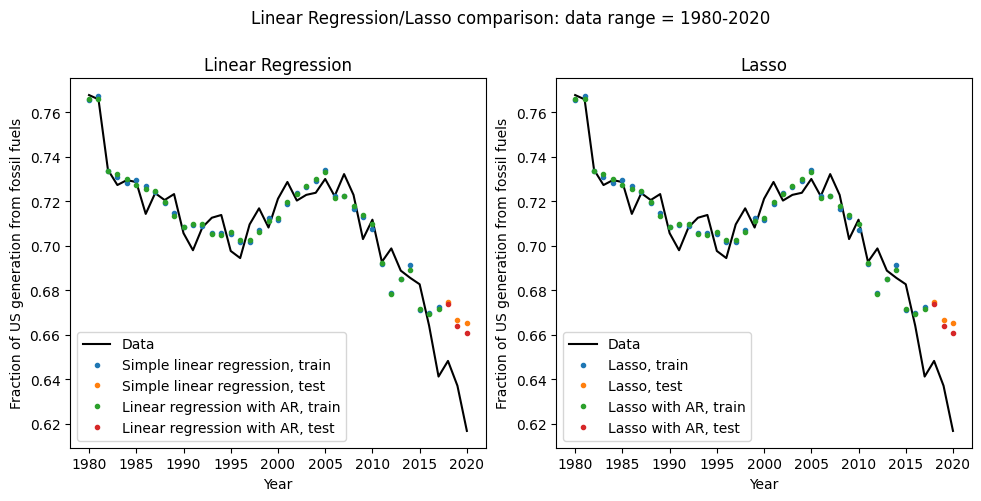

In [ ]:
f, axs = plt.subplots(1,2,figsize=(10,5))

f.suptitle(f'Linear Regression/Lasso comparison: data range = {start_year}-{end_year}')

plt.subplot(1,2,1)
plt.tight_layout(pad=2)

plt.plot(y.index, y, '-k', label='Data')

plt.plot(X_train.index, model.predict(X_train), '.', label='Simple linear regression, train')
plt.plot(X_test.index, model.predict(X_test), '.', label='Simple linear regression, test')

plt.plot(X_with_ar_train.index, model_with_ar.predict(X_with_ar_train), '.', label='Linear regression with AR, train')
plt.plot(X_with_ar_test.index, model_with_ar.predict(X_with_ar_test), '.', label='Linear regression with AR, test')

plt.xlabel('Year')
plt.ylabel('Fraction of US generation from fossil fuels')
plt.title('Linear Regression')
plt.legend()

plt.subplot(1,2,2)

plt.plot(y.index, y, '-k', label='Data')

plt.plot(X_train.index, lasso_model.predict(X_train), '.', label='Lasso, train')
plt.plot(X_test.index, lasso_model.predict(X_test), '.', label='Lasso, test')

plt.plot(X_with_ar_train.index, lasso_with_ar_model.predict(X_with_ar_train), '.', label='Lasso with AR, train')
plt.plot(X_with_ar_test.index, lasso_with_ar_model.predict(X_with_ar_test), '.', label='Lasso with AR, test')

plt.xlabel('Year')
plt.ylabel('Fraction of US generation from fossil fuels')
plt.title('Lasso')
plt.legend()


As we see above, for the start year of 1980 (including all of our predictor data), the addition of an AutoRegression predictor does slightly help our Linear Regression model. However, looking at our coefficients printed above, the other predictor coefficients in our Linear Regression model are not lower in amplitude than the AutoRegression coefficient, indicating that the other predictors are also still relevant.

Additionally, our Lasso model appears to not want to shrink any coefficients (when optimizing for the test R^2 score). Looking at the alpha cross-validation plots, we see that for larger alphas, our AutoRegression coefficient was not brought to zero any faster than the other coefficients, indicating it is about as useful as a predictor as the other predictors.

###         Optimizing Data Range

Let us now perform cross-validation to optimize our data range by maximizing our test R^2 score for our linear regression model.

In [ ]:
start_years = [i for i in range(1980, 2010)]

test_with_ar_scores = []
for start_year in start_years:
    test_size = round(2.5/(end_year-start_year),2)

    X = scaled_predictors.loc[start_year:end_year]
    y = carbon_df['Carbon Fraction'].loc[start_year:end_year]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    X_ar = autoregression(carbon_df['Carbon Fraction'], best_shift).loc[start_year:end_year]

    X_with_ar = X.merge(X_ar, how='outer', left_index=True, right_index=True)
    #display(X_with_ar)

    scaler = StandardScaler().fit(X_with_ar)
    X_with_ar = pd.DataFrame(scaler.transform(X_with_ar), columns=['PV Price', 'Renewable R&D', 'Natural Gas Price', 'Coal Price', 'Population', f'AutoRegression, lag={best_shift}'], index=X_with_ar.index)

    X_with_ar_train, X_with_ar_test, y_train, y_test = train_test_split(X_with_ar, y, test_size=test_size, shuffle=False)

    model = LinearRegression().fit(X=X_train, y=y_train)
    train_score = model.score(X=X_train, y=y_train)
    test_score = model.score(X=X_test, y=y_test)

    model_with_ar = LinearRegression().fit(X=X_with_ar_train, y=y_train)
    train_with_ar_score = model_with_ar.score(X=X_with_ar_train, y=y_train)
    test_with_ar_score = model_with_ar.score(X=X_with_ar_test, y=y_test)
    test_with_ar_scores.append(test_with_ar_score)

best_score_index = test_with_ar_scores.index(max(test_with_ar_scores))
best_score = test_with_ar_scores[best_score_index]
best_start_year = start_years[best_score_index]

print(f'Best start year: {best_start_year}, test R^2 = {round(best_score,3)}')


Best start year: 1999, test R^2 = 0.988


Fascinating: we see an incredibly high test score for the start year of 1999, which is only 1 year away from our AutoRegression optimal start year of 1998!

###         Re-plotting our models: data range = 1999-2020 (cross-validated)

Below, we implement our optimal start year of 1999 and analyze our results. This is the same code as the above sections, just with the data range (and test size) appropriately adjusted (apologies for the large section of copy/pasted code; future work includes implementing sufficient functions to streamline this analysis process!):

,"Models, data range 1999-2020",Train Scores,Test Scores
0,Linear Regression,0.888761,0.492544
1,Linear Regression with AutoRegression,0.906381,0.988106
2,Lasso,0.888761,0.488212
3,Lasso with AutoRegression,0.906381,0.988033


Linear Regression coefficients:
    PV Price :  0.023
    Renewable R&D :  -0.001
    Natural Gas Price :  0.011
    Coal Price :  0.015
    Population :  -0.055
    Intercept:  0.741
Linear Regression with AutoRegression coefficients:
    PV Price :  0.008
    Renewable R&D :  -0.003
    Natural Gas Price :  0.005
    Coal Price :  0.012
    Population :  -0.02
    AutoRegression, lag=3 :  0.01
    Intercept:  0.696
LASSO coefficients (alpha=1e-06):
    PV Price :  0.023
    Renewable R&D :  -0.001
    Natural Gas Price :  0.011
    Coal Price :  0.015
    Population :  -0.055
    Intercept:  0.741
LASSO with AutoRegression coefficients (alpha=1e-06):
    PV Price :  0.008
    Renewable R&D :  -0.003
    Natural Gas Price :  0.005
    Coal Price :  0.012
    Population :  -0.02
    AutoRegression, lag=3 :  0.01
    Intercept:  0.696


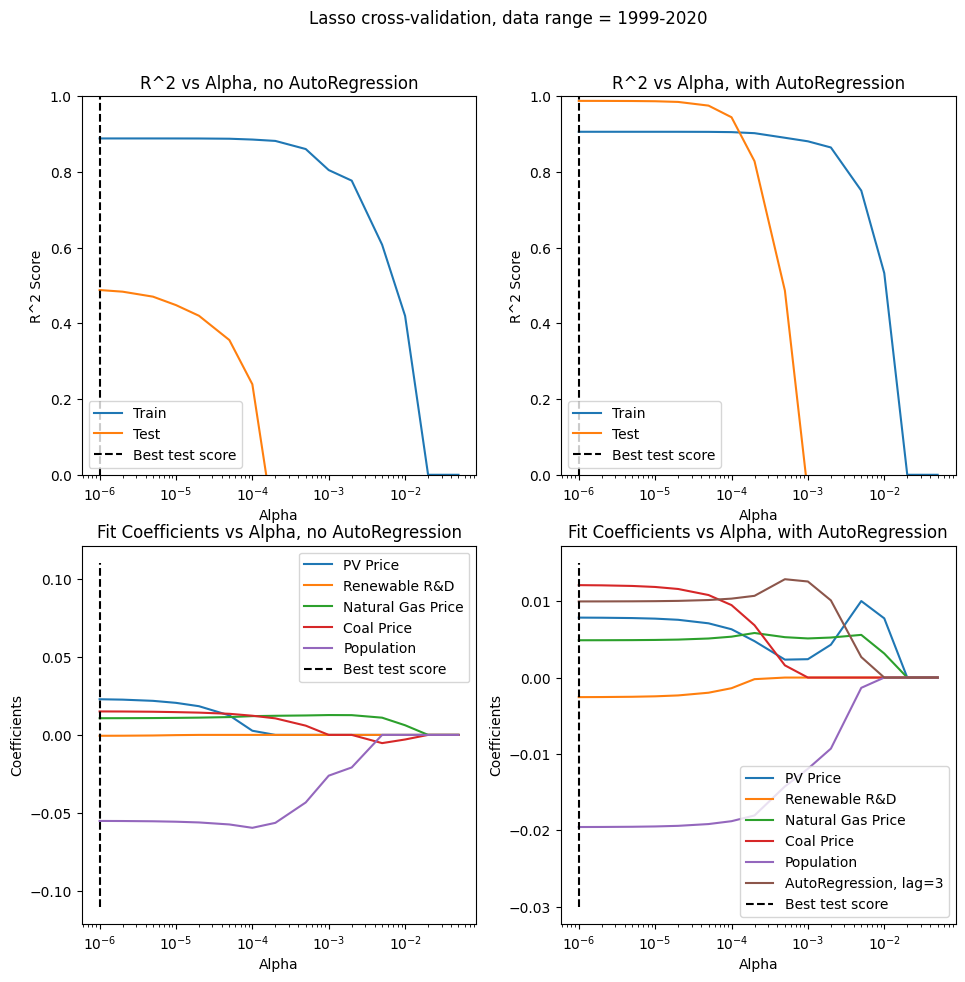

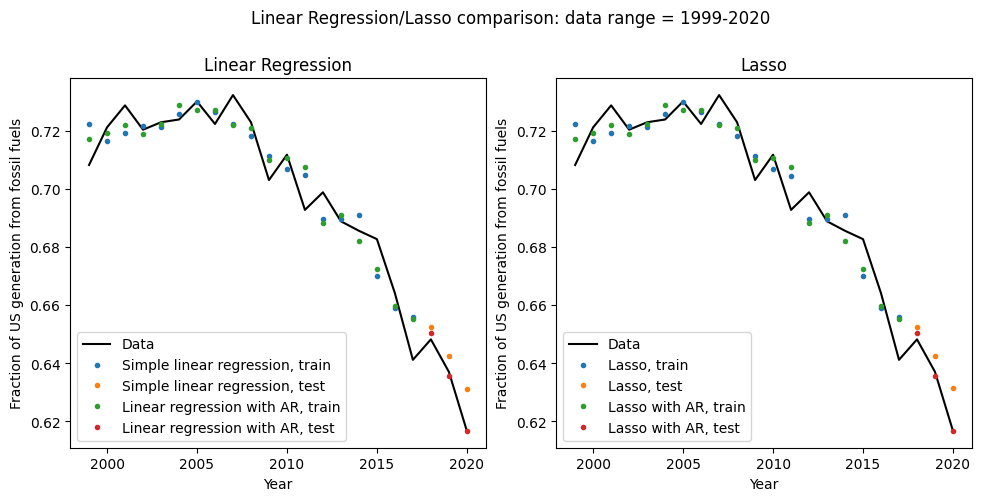

In [ ]:
start_year = 1999
end_year = 2020
test_size = round(2.5/(end_year-start_year),2)

X = scaled_predictors.loc[start_year:end_year]
y = carbon_df['Carbon Fraction'].loc[start_year:end_year]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

X_ar = autoregression(carbon_df['Carbon Fraction'], best_shift).loc[start_year:end_year]

X_with_ar = X.merge(X_ar, how='outer', left_index=True, right_index=True)
#display(X_with_ar)

scaler = StandardScaler().fit(X_with_ar)
X_with_ar = pd.DataFrame(scaler.transform(X_with_ar), columns=['PV Price', 'Renewable R&D', 'Natural Gas Price', 'Coal Price', 'Population', f'AutoRegression, lag={best_shift}'], index=X_with_ar.index)

X_with_ar_train, X_with_ar_test, y_train, y_test = train_test_split(X_with_ar, y, test_size=test_size, shuffle=False)


model = LinearRegression().fit(X=X_train, y=y_train)
train_score = model.score(X=X_train, y=y_train)
test_score = model.score(X=X_test, y=y_test)


model_with_ar = LinearRegression().fit(X=X_with_ar_train, y=y_train)
train_with_ar_score = model_with_ar.score(X=X_with_ar_train, y=y_train)
test_with_ar_score = model_with_ar.score(X=X_with_ar_test, y=y_test)


# Alpha cross-validation, no autoregression predictor:

alphas = [1e-6, 2e-6, 5e-6, 0.00001, 0.00002, 0.00005, 0.0001, .0002, .0005, 0.001, .002, .005, 0.01, .02, .05]
lasso_train_scores = []
lasso_test_scores = []
lasso_models = []

for i in range(len(alphas)):
    alpha = alphas[i]
    lasso_model = Lasso(alpha=alpha).fit(X_train, y_train)
    lasso_train_score = lasso_model.score(X_train, y_train)
    lasso_test_score = lasso_model.score(X_test, y_test)
    lasso_train_scores.append(lasso_train_score)
    lasso_test_scores.append(lasso_test_score)
    lasso_models.append(lasso_model)

alpha_index = lasso_test_scores.index(max(lasso_test_scores))
lasso_alpha = alphas[alpha_index]
lasso_model = lasso_models[alpha_index]
lasso_train_score = lasso_train_scores[alpha_index]
lasso_test_score = lasso_test_scores[alpha_index]


# Alpha cross-validation, with autoregression predictor:

alphas = [1e-6, 2e-6, 5e-6, 0.00001, 0.00002, 0.00005, 0.0001, .0002, .0005, 0.001, .002, .005, 0.01, .02, .05]
lasso_with_ar_train_scores = []
lasso_with_ar_test_scores = []
lasso_with_ar_models = []

for i in range(len(alphas)):
    alpha = alphas[i]
    lasso_with_ar_model = Lasso(alpha=alpha).fit(X_with_ar_train, y_train)
    lasso_with_ar_train_score = lasso_with_ar_model.score(X_with_ar_train, y_train)
    lasso_with_ar_test_score = lasso_with_ar_model.score(X_with_ar_test, y_test)
    lasso_with_ar_train_scores.append(lasso_with_ar_train_score)
    lasso_with_ar_test_scores.append(lasso_with_ar_test_score)
    lasso_with_ar_models.append(lasso_with_ar_model)

alpha_with_ar_index = lasso_with_ar_test_scores.index(max(lasso_with_ar_test_scores))
lasso_alpha_with_ar = alphas[alpha_with_ar_index]
lasso_with_ar_model = lasso_with_ar_models[alpha_with_ar_index]
lasso_train_with_ar_score = lasso_with_ar_train_scores[alpha_with_ar_index]
lasso_test_with_ar_score = lasso_with_ar_test_scores[alpha_with_ar_index]


f, axs = plt.subplots(2,2,figsize=(10,10))

f.suptitle(f'Lasso cross-validation, data range = {start_year}-{end_year}')

plt.subplot(2,2,1)
plt.tight_layout(pad=3)
plt.plot(alphas, lasso_train_scores, label='Train')
plt.plot(alphas, lasso_test_scores, label='Test')
plt.plot([lasso_alpha, lasso_alpha], [0,1], '--k', label='Best test score')
plt.xscale('log')
plt.ylim([0,1])
plt.xlabel('Alpha')
plt.ylabel('R^2 Score')
plt.legend()
plt.title('R^2 vs Alpha, no AutoRegression')

plt.subplot(2,2,2)
plt.plot(alphas, lasso_with_ar_train_scores, label='Train')
plt.plot(alphas, lasso_with_ar_test_scores, label='Test')
plt.plot([lasso_alpha_with_ar, lasso_alpha_with_ar], [0,1], '--k', label='Best test score')
plt.xscale('log')
plt.ylim([0,1])
plt.xlabel('Alpha')
plt.ylabel('R^2 Score')
plt.legend()
plt.title('R^2 vs Alpha, with AutoRegression')


plt.subplot(2,2,3)

plt.plot(alphas, [model.coef_ for model in lasso_models], label=X.columns)
plt.plot([lasso_alpha, lasso_alpha], [-0.11,0.11], '--k', label='Best test score')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.legend()
plt.title('Fit Coefficients vs Alpha, no AutoRegression')


plt.subplot(2,2,4)

plt.plot(alphas, [model.coef_ for model in lasso_with_ar_models], label=X_with_ar.columns)
plt.plot([lasso_alpha_with_ar, lasso_alpha_with_ar], [-0.03,0.015], '--k', label='Best test score')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.legend()
plt.title('Fit Coefficients vs Alpha, with AutoRegression')


results = pd.DataFrame()
results[f'Models, data range {start_year}-{end_year}'] = ['Linear Regression', 'Linear Regression with AutoRegression', 'Lasso', 'Lasso with AutoRegression']
results['Train Scores'] = [train_score, train_with_ar_score, lasso_train_score, lasso_train_with_ar_score]
results['Test Scores'] = [test_score, test_with_ar_score, lasso_test_score, lasso_test_with_ar_score]

display(results)

print('Linear Regression coefficients:')
for i in range(len(model.coef_)):
    print('   ',X_train.columns[i],': ', round(model.coef_[i],3))
print('    Intercept: ', round(model.intercept_,3))

print('Linear Regression with AutoRegression coefficients:')
for i in range(len(model_with_ar.coef_)):
    print('   ',X_with_ar_train.columns[i],': ', round(model_with_ar.coef_[i],3))
print('    Intercept: ', round(model_with_ar.intercept_,3))

print(f'LASSO coefficients (alpha={lasso_alpha}):')
for i in range(len(lasso_model.coef_)):
    print('   ',X_train.columns[i],': ', round(lasso_model.coef_[i],3))
print('    Intercept: ', round(lasso_model.intercept_,3))

print(f'LASSO with AutoRegression coefficients (alpha={lasso_alpha_with_ar}):')
for i in range(len(lasso_with_ar_model.coef_)):
    print('   ',X_with_ar_train.columns[i],': ', round(lasso_with_ar_model.coef_[i],3))
print('    Intercept: ', round(lasso_with_ar_model.intercept_,3))


f, axs = plt.subplots(1,2,figsize=(10,5))

f.suptitle(f'Linear Regression/Lasso comparison: data range = {start_year}-{end_year}')

plt.subplot(1,2,1)
plt.tight_layout(pad=2)

plt.plot(y.index, y, '-k', label='Data')

plt.plot(X_train.index, model.predict(X_train), '.', label='Simple linear regression, train')
plt.plot(X_test.index, model.predict(X_test), '.', label='Simple linear regression, test')

plt.plot(X_with_ar_train.index, model_with_ar.predict(X_with_ar_train), '.', label='Linear regression with AR, train')
plt.plot(X_with_ar_test.index, model_with_ar.predict(X_with_ar_test), '.', label='Linear regression with AR, test')

plt.xlabel('Year')
plt.ylabel('Fraction of US generation from fossil fuels')
plt.title('Linear Regression')
plt.legend()

plt.subplot(1,2,2)

plt.plot(y.index, y, '-k', label='Data')

plt.plot(X_train.index, lasso_model.predict(X_train), '.', label='Lasso, train')
plt.plot(X_test.index, lasso_model.predict(X_test), '.', label='Lasso, test')

plt.plot(X_with_ar_train.index, lasso_with_ar_model.predict(X_with_ar_train), '.', label='Lasso with AR, train')
plt.plot(X_with_ar_test.index, lasso_with_ar_model.predict(X_with_ar_test), '.', label='Lasso with AR, test')

plt.xlabel('Year')
plt.ylabel('Fraction of US generation from fossil fuels')
plt.title('Lasso')
plt.legend()


Again, our Lasso model is optimal for our minimum alpha value, representing no coefficient minimization occurring. Our plotted results show the Linear Regression model with AutoRegression performing very well on both the train and test data.

We are happy with the performance of this linear regression model. We now will extrapolate our predictor variables into the future, and rerun our model to estimate our response variable through to 2035.

##     Projecting Model to 2035

###         PV Module Cost

The DOE estimates that PV modules will decrease to about 40% of their 2020 cost by 2030 (source here). Being conservative, we assume this target will be reached in 2035 and perform a linear extrapolation:

In [ ]:
PV_cost_2020 = predictors['PV Price'].loc[2020]
PV_cost_2035 = PV_cost_2020 * 0.4 # From DOE reference (see text above)
PV_projected = [PV_cost_2020 for i in range(2021,2036)]
for i in range(1, len(PV_projected)):
    PV_projected[i] = round(PV_projected[i-1] + (PV_cost_2035 - PV_cost_2020)/len(PV_projected),3)
print('Projected PV price in $/W, 2021-2035: ')
print(PV_projected)


Projected PV price in $/W, 2021-2035: 
[0.2, 0.192, 0.184, 0.176, 0.168, 0.16, 0.152, 0.144, 0.136, 0.128, 0.12, 0.112, 0.104, 0.096, 0.088]


The values above represent a continued decrease in the cost of PV modules. We plot these projections below:

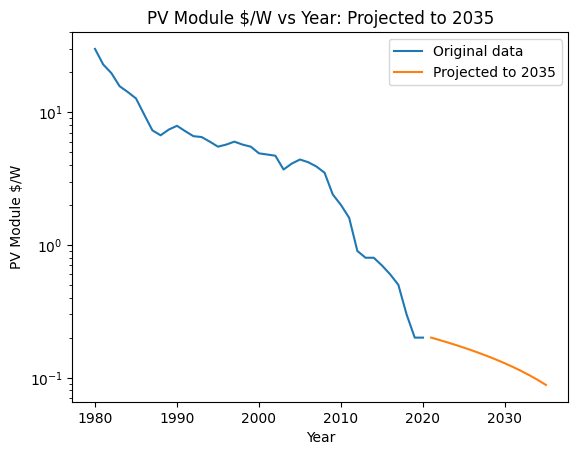

In [ ]:
plt.plot(predictors.index, predictors['PV Price'], label='Original data')
plt.plot(range(2021,2036), PV_projected, label='Projected to 2035')
plt.yscale('log')
plt.xlabel('Year')
plt.ylabel('PV Module $/W')
plt.title('PV Module $/W vs Year: Projected to 2035')
plt.legend()

The above plot appears fairly reasonable; we are happy with this projection. 

###         Renewable R&D

Looking at the plot of our historical Renewable R&D data (plotted in blue below), we see that R&D investment increased from about 2006 to 2010, then maintained similar levels for the following decade. For our projection, we calculate the mean of the renewable R&D value from 2010 to 2020 and assume this value plus/minus a noise factor until 2035. This feels somewhat conservative, given the priority on the renewable transition. There is definitely a lot of uncertainty here, however, and so ideally, multiple models would fit the variety of reasonable projections for R&D (see Future Work).

Text(0.5, 1.0, 'Renewable R&D vs Year: Projected to 2035')

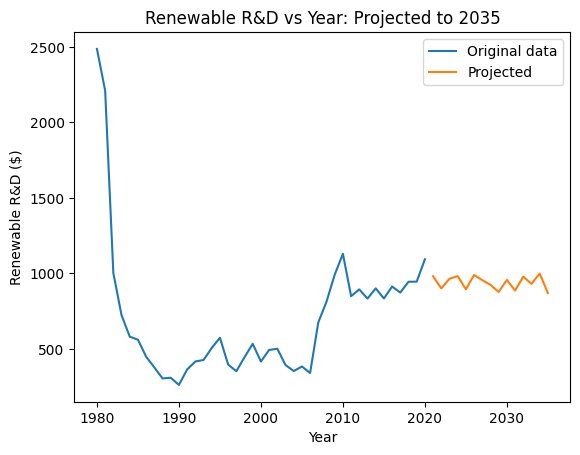

In [ ]:
#renewable_RD_2020 = predictors['Renewable R&D'].loc[2020]
renewable_RD_mean_2010_2020 = np.mean(predictors['Renewable R&D'].loc[2010:2020])
renewable_RD_projected = [renewable_RD_mean_2010_2020-75+150*np.random.rand() for i in range(2021,2036)]

plt.plot(predictors.index, predictors['Renewable R&D'], label='Original data')
plt.plot(range(2021,2036), renewable_RD_projected, label = 'Projected')
plt.xlabel('Year')
plt.ylabel('Renewable R&D ($)')
plt.legend()
plt.title('Renewable R&D vs Year: Projected to 2035')

The above looks reasonable, given our high uncertainty on this value.

###         Natural Gas and Coal Prices

Fossil fuel prices are notoriously difficult to model exactly, as they are some of the largest global markets. Natural gas prices have been particularly noisy in recent years (see the blue curve below or the news!), so we definitely want to include noise in our projection. We will project natural gas and coal by taking their mean values since 2010 and adding a noise factor. 

Text(0.5, 1.0, 'Natural Gas Price vs Year: Projected to 2035')

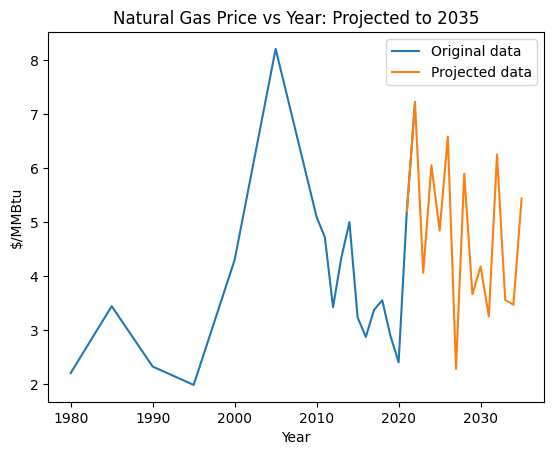

In [ ]:
coal_natural_gas_df = pd.read_csv('/work/coal_and_natural_gas_prices_1980-2022.csv')
coal_natural_gas_df = coal_natural_gas_df.set_index('Year').dropna(how='all', axis=1).dropna(how='all', axis=0)
#display(coal_natural_gas_df)

projected_gas = [np.mean(coal_natural_gas_df['Natural Gas'].loc[2010:2022])-2+5*np.random.rand() for i in range(2023,2036)]
projected_gas = np.append(coal_natural_gas_df['Natural Gas'].loc[2021:2023].values, projected_gas)

plt.plot(coal_natural_gas_df.index, coal_natural_gas_df['Natural Gas'], label='Original data')
plt.plot(range(2021,2036), projected_gas, label='Projected data')

plt.xlabel('Year')
plt.ylabel('$/MMBtu')
plt.legend()
plt.title('Natural Gas Price vs Year: Projected to 2035')

Text(0.5, 1.0, 'Coal Price vs Year: Projected to 2035')

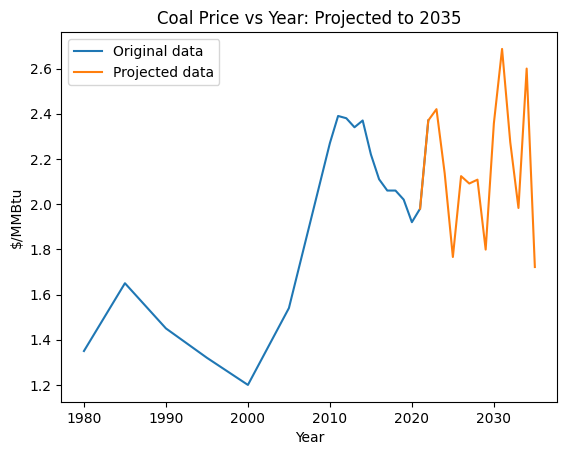

In [ ]:
projected_coal = [np.mean(coal_natural_gas_df['Coal'].loc[2010:2022])-0.5+np.random.rand() for i in range(2023,2036)]
projected_coal = np.append(coal_natural_gas_df['Coal'].loc[2021:2023].values, projected_coal)

plt.plot(coal_natural_gas_df.index, coal_natural_gas_df['Coal'], label='Original data')
plt.plot(range(2021,2036), projected_coal, label='Projected data')

plt.xlabel('Year')
plt.ylabel('$/MMBtu')
plt.legend()
plt.title('Coal Price vs Year: Projected to 2035')

Our projections appear a bit noisier than the historical data, but we think these projections are reasonable and will likely reflect in somewhat noisier model results, which isn’t the worst thing given our lack of certainty in these projections.

###         US Population

The US Census provides projected population values (see here). We took these values through to 2035 and included them with our historical data below.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'US Population vs Year: Projected to 2035')

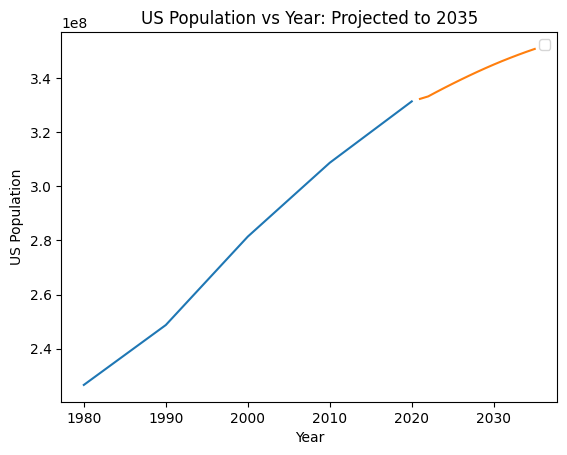

In [ ]:
plt.plot(predictors.index, predictors['Population'])
population_projection = predictors['Population'].values
pop_proj_data = [333288000,334906000,336482000,338016000,339513000,340970000,342385000,343754000,345074000,346339000,347545000,348702000,349808000,350861000]
pop_proj_data = [(population_projection[-1]+pop_proj_data[0])/2] + pop_proj_data
population_projection = pop_proj_data
plt.plot(range(2021,2036), pop_proj_data)
plt.xlabel('Year')
plt.ylabel('US Population')
plt.legend()
plt.title('US Population vs Year: Projected to 2035')

The above population plot looks great; a big thank you to the dedicated work of US Census workers!

###         Merge Projected Predictors

As we merge our projected predictors, our AutoRegression predictor is the tricky element. We use the projected values from our AutoRegression model much earlier in this notebook to fill the AutoRegression column here (shifted by our lag value of 3 years, of course).

In [ ]:
predictors_proj = pd.DataFrame()
to_merge = [PV_projected, renewable_RD_projected, projected_gas, projected_coal, population_projection]
column_names = ['PV Price', 'Renewable R&D', 'Natural Gas Price', 'Coal Price', 'Population']
for i in range(len(to_merge)):
    pred = to_merge[i]
    column = column_names[i]
    pred = pd.DataFrame(pred)
    pred.columns = [column]
    pred.index=range(2021,2036)
    if len(predictors_proj)==0:
        predictors_proj = pred
    else:
        predictors_proj[column] = pred

predictors_proj[f'AutoRegression, lag={shift}'] = [0 for i in range(2021,2036)]
for i in range(2021,2026):
    predictors_proj[f'AutoRegression, lag={shift}'].loc[i] = y_all_years.loc[i-shift]
predictors_proj[f'AutoRegression, lag={shift}'].loc[2026:] = y_test_pred[1:-3]
display(predictors_proj)


/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,PV Price,Renewable R&D,Natural Gas Price,Coal Price,Population,"AutoRegression, lag=3"
2021,0.200,981.434000,5.200000,1.980000,332368640.5,0.648243
2022,0.192,900.788907,7.220000,2.370000,333288000.0,0.637075
2023,0.184,964.424938,4.058818,2.420139,334906000.0,0.616745
2024,0.176,982.196796,6.054426,2.136413,336482000.0,0.620824
2025,0.168,894.621262,4.840271,1.766047,338016000.0,0.611639
2026,0.160,989.699014,6.584369,2.123798,339513000.0,0.587641
2027,0.152,955.084042,2.279553,2.091087,340970000.0,0.575787
2028,0.144,924.489154,5.896284,2.108160,342385000.0,0.538022
2029,0.136,876.612799,3.660408,1.798798,343754000.0,0.544817
2030,0.128,956.545253,4.177546,2.357181,345074000.0,0.529518


The above predictors DataFrame contains all of our projected predictors, unscaled. We cannot simply scale this data and feed it into our existing model prediction since the scaling changes the relative values! Therefore, we must attach this to our historical predictor data (1999-2020), scale everything together, and finally train our final model.

###         Merge projected predictors with historical predictors

Here, we combine all of our predictor data (1999-2020 and 2021-2035) into one complete (but still unscaled) predictor dataset (1999-2035).

In [ ]:
X = predictors.loc[1999:2020]
Xprior_ar = autoregression(carbon_df['Carbon Fraction'], best_shift).loc[1999:2020]
Xprior_with_ar = X.merge(Xprior_ar, how='outer', left_index=True, right_index=True)
Xprior_with_ar = predictors.loc[1999:2020].merge(X_ar, how='outer', left_index=True, right_index=True)
Xprior_with_ar.columns = columns=['PV Price', 'Renewable R&D', 'Natural Gas Price', 'Coal Price', 'Population', f'AutoRegression, lag={best_shift}']
#display(Xprior_with_ar)

predictors_1999_2035 = Xprior_with_ar.merge(predictors_proj, how='outer')
predictors_1999_2035.index = range(1999,2036)
display(predictors_1999_2035)

,PV Price,Renewable R&D,Natural Gas Price,Coal Price,Population,"AutoRegression, lag=3"
1999,5.500,533.899186,3.836000,1.224000,278150703.0,0.694504
2000,4.900,416.698537,4.300000,1.200000,281421906.0,0.709649
2001,4.800,493.130034,5.082000,1.268000,284154269.0,0.716886
2002,4.700,501.307304,5.864000,1.336000,286886632.0,0.708237
2003,3.700,393.532350,6.646000,1.404000,289618996.0,0.721182
2004,4.100,353.602807,7.428000,1.472000,292351359.0,0.728747
2005,4.400,383.645634,8.210000,1.540000,295083722.0,0.720376
2006,4.200,340.691067,7.586000,1.686000,297816085.0,0.722938
2007,3.900,675.838439,6.962000,1.832000,300548448.0,0.723884
2008,3.500,812.593937,6.338000,1.978000,303280812.0,0.730088


The above DataFrame contains 37 rows, representing the 37 years of data from 1999 to 2035.

###         Scale all predictors

We now scale this full predictors dataset.

In [ ]:
scaler = StandardScaler().fit(predictors_1999_2035)
predictors_scaled_1999_2035 = pd.DataFrame(scaler.transform(predictors_1999_2035), columns=['PV Price', 'Renewable R&D', 'Natural Gas Price', 'Coal Price', 'Population', f'AutoRegression, lag={best_shift}'], index=range(1999,2036))

In [ ]:
display(predictors_scaled_1999_2035.describe())

,PV Price,Renewable R&D,Natural Gas Price,Coal Price,Population,"AutoRegression, lag=3"
count,3.700000e+01,3.700000e+01,3.700000e+01,3.700000e+01,3.700000e+01,3.700000e+01
mean,-1.200241e-17,4.223348e-16,8.701748e-17,-1.164234e-15,-5.341073e-16,4.800964e-16
std,1.013794e+00,1.013794e+00,1.013794e+00,1.013794e+00,1.013794e+00,1.013794e+00
min,-7.946592e-01,-2.161583e+00,-1.671328e+00,-2.053184e+00,-1.951377e+00,-2.486520e+00
25%,-7.551664e-01,-1.615875e-02,-8.566118e-01,-5.815490e-01,-7.992436e-01,-5.626689e-01
50%,-5.686726e-01,3.567642e-01,-2.918301e-02,1.826845e-01,1.799206e-01,4.799843e-01
75%,1.076861e+00,6.382909e-01,7.494341e-01,7.379988e-01,8.618832e-01,8.130584e-01
max,2.173883e+00,1.426786e+00,2.131767e+00,1.811871e+00,1.382152e+00,9.770018e-01


We see above that our scaling worked.

###         Split data and train model

Now that we have our full-scaled predictors dataset, we’re ready to model! We start by splitting our predictors into “train” and “test.” In this case, these concepts take on slightly different meanings since we cannot really test our future predictions. This split is still useful though, as we will train our model on all of our data up to 2022 (the most recent complete data), and then have our model predict our “X_test”, which corresponds to our predictors from 2023-2035. The ’train_size’ seen in the code below is the value necessary for only the years 1999-2022 to be included in train variables. We artificially set y values past 2022 to 0 since we do not know the grid generation values in the future (hence the point of this project!). This is ok since we have no use for y_test.

In [ ]:
y = carbon_df['Carbon Fraction'].loc[1999:2023]
for i in range(2023, 2036):
    y[i] = 0

X_train, X_test, y_train, y_test = train_test_split(predictors_scaled_1999_2035, y, train_size=0.649, shuffle=False)

model = LinearRegression().fit(X_train, y_train) # this is really all of the data we have!

train_score = model.score(X_train, y_train)
print(f'Train R^2 score: {round(train_score,3)}')


Train R^2 score: 0.966


Our train R^2 score is comparable to what we saw in our earlier modeling attempts! This indicates that we have not catastrophically messed anything up to this point. We plot our model predictions below.

##     Final Model Plot: Projecting to 2035 with all predictors

Below, we plot our final model’s fit to our projected predictors to see what our model thinks our electricity grid might look like come 2035.

Fraction reached in 2035 (projected): 0.43


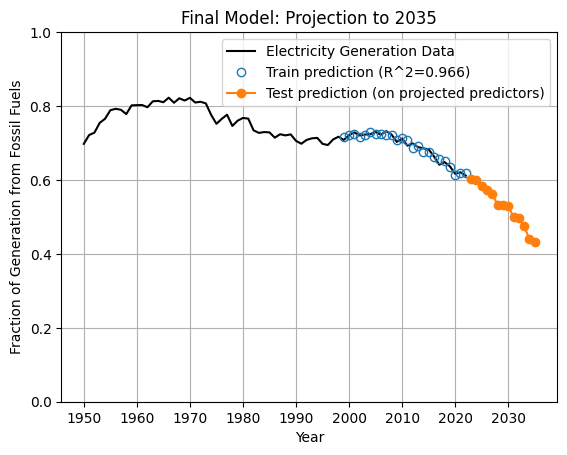

In [ ]:
y = carbon_df['Carbon Fraction'].loc[1950:2022]

plt.plot(range(1950,2023), y, '-k', label='Electricity Generation Data')
plt.plot(range(1999,2023), model.predict(X_train), 'o', markerfacecolor='none', label=f'Train prediction (R^2={round(train_score,3)})')
plt.plot(range(2023,2036), model.predict(X_test), 'o-', label='Test prediction (on projected predictors)')
plt.legend()
plt.grid()
plt.xlabel('Year')
plt.ylabel('Fraction of Generation from Fossil Fuels')
plt.ylim([0,1])
plt.xticks([1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030])
plt.title('Final Model: Projection to 2035')

print(f'Fraction reached in 2035 (projected): {round(model.predict(X_test)[-1],2)}')

We presented the above plot to show the big picture: fossil fuel generation data back to 1950, our model fitting the optimal training set of 1999-2022 data, and our model fitting our projected predictors to 2035. By eye, this projection seems reasonable: the curve appears quite smooth, with a gradually increasing reduction rate towards lower fossil fuel usage.

Below, we compare our final model to our simpler AutoRegression-only model from earlier.

Text(0.5, 1.0, 'Model comparison: Full Model (all predictors) vs AutoRegression Only Model')

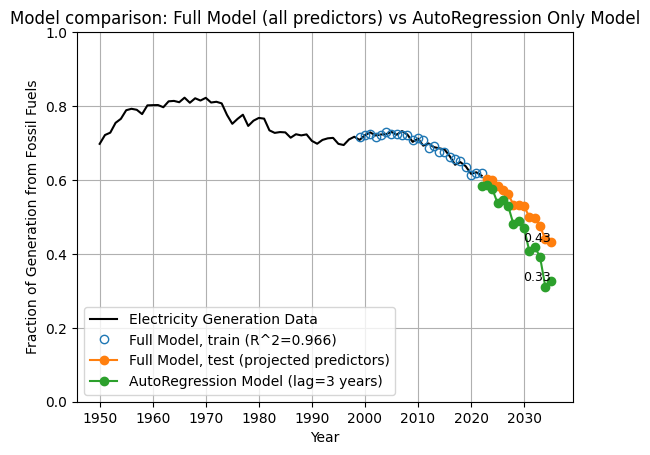

In [ ]:
y = carbon_df['Carbon Fraction'].loc[1950:2022]

plt.plot(range(1950,2023), y, '-k', label='Electricity Generation Data')
plt.plot(range(1999,2023), model.predict(X_train), 'o', markerfacecolor='none', label=f'Full Model, train (R^2={round(train_score,3)})')
plt.plot(range(2023,2036), model.predict(X_test), 'o-', label='Full Model, test (projected predictors)')
plt.plot(future_years, y_test_pred, 'o-', label=f'AutoRegression Model (lag={shift} years)')

plt.text(2035, model.predict(X_test)[-1].item(), f"{model.predict(X_test)[-1].item():.2f}", fontsize=9, horizontalalignment='right')
plt.text(future_years[-1], y_test_pred[-1].item(), f"{y_test_pred[-1].item():.2f}", fontsize=9, horizontalalignment='right')

plt.legend()
plt.grid()
plt.xlabel('Year')
plt.ylabel('Fraction of Generation from Fossil Fuels')
plt.ylim([0,1])
plt.xticks([1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030])
plt.title('Model comparison: Full Model (all predictors) vs AutoRegression Only Model')

We see a decent gap between these two models: the AutoRegression model is more optimistic, predicting a fossil fuel generation fraction of 0.33 in 2035, compared to the approximately 0.44 value from our Full Model. This implies that including our non-autoregression predictors increases the predicted generation fraction. Perhaps modification to the predictor projected values could decrease the Full Model predictions to or below that of the AutoRegression Model (see Future Work below).

Overall, we are happy with the above plot, as it captures what we set out to accomplish: we have successfully used the generation data and predictor data to model future generation values and demonstrated that including different types of predictors results in different predicted values.

# Future Work

Given the importance and scale of our chosen topic, this project has much-remaining potential. We discuss a few areas for continued work below.

##     Adjusting Predictor Projections to “Optimize” Generation Fraction

The main policy objective of this project was to be able to perform cross-validation to our predictor projections to see what (realistic) values of our predictors result in the lowest modeled fossil fuel generation fraction. This would potentially inform the energy policy community, as our results might set clear goals for certain predictors to reach by 2035. Some predictors, like population, we would not be interested in making such recommendations about (as we do not want to be suspected of suggesting population change to hit policy goals!), so we would only perform this cross-validation on our predictors with potential policy influence: PV price, renewable energy R&D, natural gas price, and coal price.

##     Including Confidence Intervals

Similarly, we could perform multiple modeling fits to various projected predictor values, capturing our uncertainty in future values. From the range of fits our models provide, we could then construct confidence intervals (such as 95%) in our above plot.

##     Including Lithium-Ion Battery Predictor (and/or other predictors)

Of course, we can incorporate our Li-ion predictor data since we only used data from 1998 onward, and we have Li-ion prices from 1991. We don’t suspect this predictor would add much not captured by PV price since the two are functionally quite similar, but checking this with Lasso, for example, would be wise.

Additionally, there is a whole world of data from which additional or alternative predictors could be chosen. Future work could include running similar models on completely different predictors to see how different predictor types affect the modeled generation values.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bd341797-9619-4663-93f6-20e84ffb691c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>